In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import mediapipe as mp
import warnings
import gc

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Configuration
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Define paths and classes
BASE_DIR = "FER-2013"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")
CLASSES = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

print("Libraries imported and configuration set.")

Libraries imported and configuration set.


### Milestone 1 — Face Detection & Visual Check

In [6]:
# Load a small sample from each class in data/train.
def load_data(data_dir):
    """Loads images (48x48 grayscale, converted to 3-channel BGR) and labels."""
    data = []
    labels = []
    label_map = {emotion: i for i, emotion in enumerate(CLASSES)}
    
    print(f"Loading data from: {data_dir}")
    
    for emotion in CLASSES:
        class_path = os.path.join(data_dir, emotion)
        if not os.path.exists(class_path):
            print(f"Warning: Path not found: {class_path}")
            continue
            
        for filename in os.listdir(class_path):
            if filename.endswith(('.jpg', '.png')):
                img_path = os.path.join(class_path, filename)
                # Read image as grayscale
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                
                if img is not None and img.shape == (48, 48):
                    # Convert grayscale to 3 channels (required for MediaPipe/CNN backbones)
                    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
                    data.append(img_bgr)
                    labels.append(label_map[emotion])
    
    return np.array(data), np.array(labels)

# Load data
print("Loading training data...")
X_train_raw, y_train = load_data(TRAIN_DIR)
print("Loading test data...")
X_test_raw, y_test = load_data(TEST_DIR)

print("\n--- Train–Test split overview ---")
print(f"Train set shape: {X_train_raw.shape}, Labels shape: {y_train.shape}")
print(f"Test set shape: {X_test_raw.shape}, Labels shape: {y_test.shape}")

# Class distribution check
train_counts = pd.Series(y_train).value_counts().sort_index()
test_counts = pd.Series(y_test).value_counts().sort_index()
print("\nClass Counts (Train):", {CLASSES[i]: count for i, count in train_counts.items()})
print("Class Counts (Test):", {CLASSES[i]: count for i, count in test_counts.items()})

# Calculate class weights for handling imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("\nClass Weights for handling imbalance:", class_weight_dict)

Loading training data...
Loading data from: FER-2013\train
Loading test data...
Loading data from: FER-2013\test

--- Train–Test split overview ---
Train set shape: (28709, 48, 48, 3), Labels shape: (28709,)
Test set shape: (7178, 48, 48, 3), Labels shape: (7178,)

Class Counts (Train): {'angry': 3995, 'disgust': 436, 'fear': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprise': 3171}
Class Counts (Test): {'angry': 958, 'disgust': 111, 'fear': 1024, 'happy': 1774, 'neutral': 1233, 'sad': 1247, 'surprise': 831}

Class Weights for handling imbalance: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [7]:
try:
    # Initialize MediaPipe components for Landmark extraction
    mp_face_mesh = mp.solutions.face_mesh
    mp_drawing = mp.solutions.drawing_utils

    # Indices for key points (used for normalization in Track A)
    LEFT_EYE_IDX = 133
    RIGHT_EYE_IDX = 362
    
    # Test MediaPipe initialization
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.3) as test_face_mesh:
        test_result = test_face_mesh.process(np.ones((48, 48, 3), dtype=np.uint8))
    print("MediaPipe initialized successfully")
    
except Exception as e:
    print(f"MediaPipe initialization failed: {e}")
    print("Falling back to Haar Cascade for face detection")
    
    # Initialize Haar Cascade as fallback
    haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    mp_face_mesh = None

MediaPipe initialized successfully


Running Milestone 1: Face Detection Visualization...


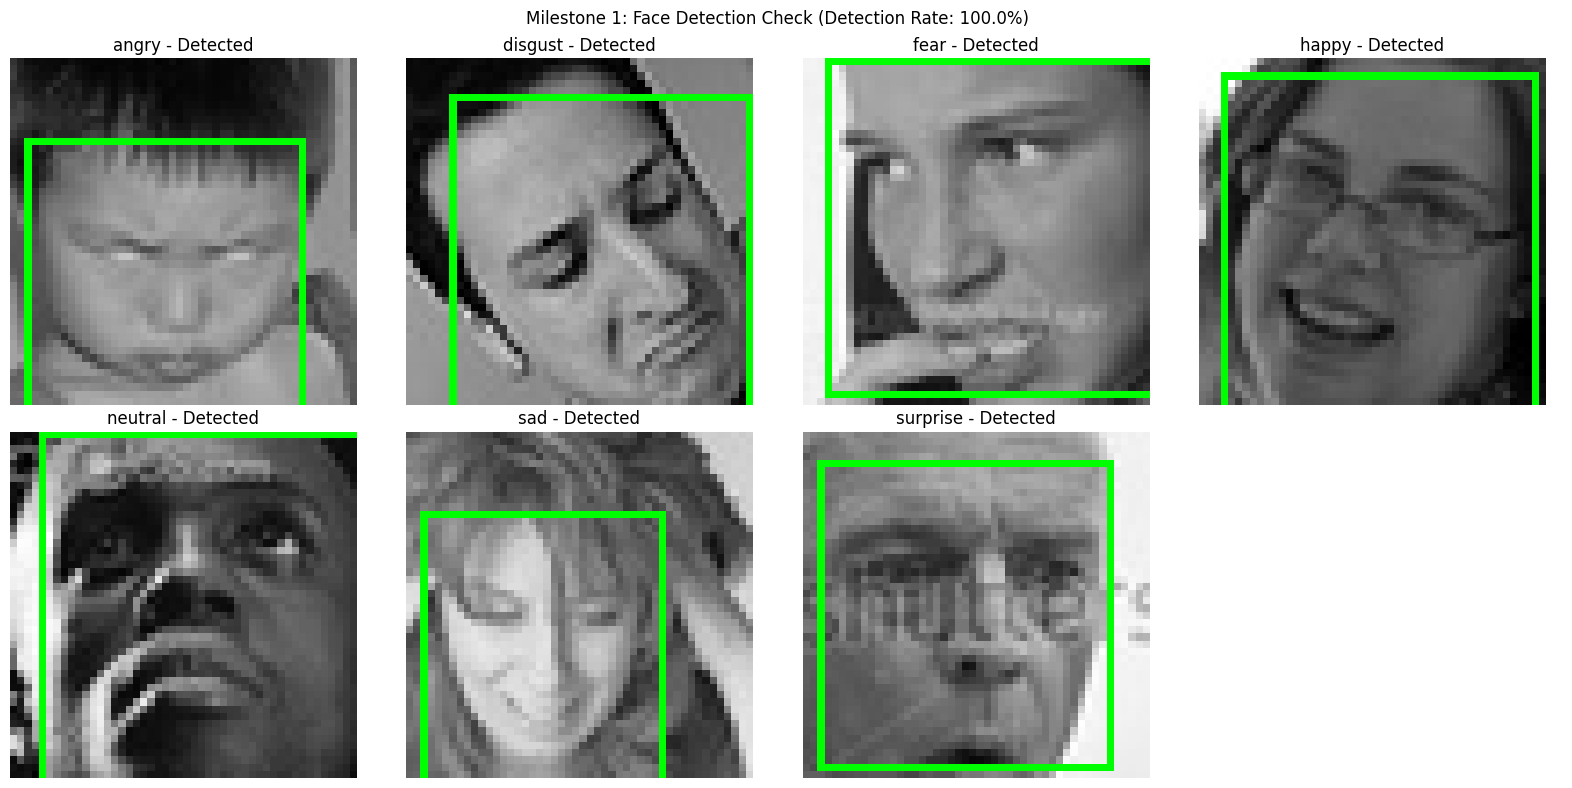

Face detection rate on samples: 100.0%


In [ ]:
def detect_faces_mediapipe(image):
    """Detect faces using MediaPipe and return bounding boxes."""
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, 
                              min_detection_confidence=0.5) as face_mesh:
        results = face_mesh.process(image)
        
        if results.multi_face_landmarks:
            h, w = image.shape[:2]
            face_landmarks = results.multi_face_landmarks[0]
            
            # Extract bounding box from landmarks
            x_coords = [landmark.x * w for landmark in face_landmarks.landmark]
            y_coords = [landmark.y * h for landmark in face_landmarks.landmark]
            
            x_min, x_max = int(min(x_coords)), int(max(x_coords))
            y_min, y_max = int(min(y_coords)), int(max(y_coords))
            
            return [(x_min, y_min, x_max, y_max)]
    
    return []

def visualize_face_detection(samples_per_class=2):
    """Visualize face detection on sample images from each class."""
    fig, axes = plt.subplots(len(CLASSES), samples_per_class, figsize=(15, 20))
    
    for i, emotion in enumerate(CLASSES):
        # Get samples for this class
        class_indices = np.where(y_train == i)[0]
        sample_indices = class_indices[:samples_per_class]
        
        for j, idx in enumerate(sample_indices):
            img = X_train_raw[idx].copy()
            bboxes = detect_faces_mediapipe(img)
            
            # Draw bounding boxes
            for bbox in bboxes:
                x_min, y_min, x_max, y_max = bbox
                cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            
            # Display
            ax = axes[i, j] if samples_per_class > 1 else axes[i]
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax.set_title(f'{emotion} - Face Detected: {len(bboxes) > 0}')
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

print("Running Milestone 1: Face Detection Visualization...")
visualize_face_detection()

In [ ]:
# Cell 5: Milestone 2 - Track A: Landmark Feature Extraction
def extract_and_normalize_landmarks(image_bgr, face_mesh):
    """Extracts 468 normalized landmarks (centered by eye midpoint, scaled by IPD)."""
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image_rgb)
    
    if not results.multi_face_landmarks:
        return None
    
    landmarks = results.multi_face_landmarks[0].landmark
    
    coords = np.array([[lm.x, lm.y] for lm in landmarks])
    
    # Calculate IPD and center
    p_left = coords[LEFT_EYE_IDX]
    p_right = coords[RIGHT_EYE_IDX]
    ipd = np.linalg.norm(p_left - p_right)
    
    if ipd == 0: 
        return None
        
    center = (p_left + p_right) / 2
    
    # Normalize
    normalized_coords = (coords - center) / ipd
    
    return normalized_coords.flatten() # 936 features

def get_landmark_features_and_labels(X_raw, y_raw):
    """
    Returns:
      features: np.array of shape (n_survived, 936)
      filtered_labels: np.array shape (n_survived,)
      survived_indices: list of original indices in X_raw that produced features
    """
    features = []
    filtered_labels = []
    survived_indices = []
    
    with mp_face_mesh.FaceMesh(
        static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5) as face_mesh:
        
        for i, img in enumerate(X_raw):
            feature = extract_and_normalize_landmarks(img, face_mesh)
            if feature is not None:
                features.append(feature)
                filtered_labels.append(y_raw[i])
                survived_indices.append(i)
                
    return np.array(features), np.array(filtered_labels), np.array(survived_indices)


print("\n--- Track A: Landmark Feature Extraction (936 features) ---")
X_train_lm, y_train_lm = get_landmark_features_and_labels(X_train_raw, y_train)
X_test_lm, y_test_lm = get_landmark_features_and_labels(X_test_raw, y_test)

if len(X_train_lm) > 0:
    print(f"Landmark Train Features shape: {X_train_lm.shape}, Labels shape: {y_train_lm.shape}")
    print(f"Landmark Test Features shape: {X_test_lm.shape}, Labels shape: {y_test_lm.shape}")
else:
    print("No landmark features extracted. Proceeding with CNN features only.")


--- Track A: Landmark Feature Extraction (936 features) ---
Extracting landmark features...
Processed 0/28709 images...
Processed 1000/28709 images...
Processed 2000/28709 images...
Processed 3000/28709 images...
Processed 4000/28709 images...
Processed 5000/28709 images...
Processed 6000/28709 images...
Processed 7000/28709 images...
Processed 8000/28709 images...
Processed 9000/28709 images...
Processed 10000/28709 images...
Processed 11000/28709 images...
Processed 12000/28709 images...
Processed 13000/28709 images...
Processed 14000/28709 images...
Processed 15000/28709 images...
Processed 16000/28709 images...
Processed 17000/28709 images...
Processed 18000/28709 images...
Processed 19000/28709 images...
Processed 20000/28709 images...
Processed 21000/28709 images...
Processed 22000/28709 images...
Processed 23000/28709 images...
Processed 24000/28709 images...
Processed 25000/28709 images...
Processed 26000/28709 images...
Processed 27000/28709 images...
Processed 28000/28709 im

In [ ]:
# Cell 6: Milestone 2 - Track B: CNN Deep Feature Extraction
def extract_cnn_features_batched(X_raw, batch_size=32, target_size=(224,224), convert_bgr2rgb=True):
    """Extracts deep features using MobileNetV2 in batches (ensures RGB channel ordering)."""
    
    num_images = len(X_raw)
    all_features = []
    for i in range(0, num_images, batch_size):
        batch_raw = X_raw[i:i + batch_size]
        
        # 1. Resize and convert BGR->RGB if needed
        resized_images = []
        for img in batch_raw:
            img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
            if convert_bgr2rgb:
                img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
            resized_images.append(img_resized)
            
        X_resized_batch = np.array(resized_images, dtype=np.float32)
        
        # 2. Preprocess batch (MobileNetV2 expects RGB)
        X_processed_batch = preprocess_input(X_resized_batch)
        
        # 3. Extract features
        features_batch = feature_extractor.predict(X_processed_batch, verbose=0)
        all_features.append(features_batch)
        
        # cleanup
        del X_resized_batch, X_processed_batch, features_batch
        gc.collect()
        
    return np.concatenate(all_features, axis=0)

# Load MobileNetV2 backbone (1280 features)
print("Loading MobileNetV2 feature extractor...")
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

print("\n--- Track B: CNN Deep Feature Extraction (1280 features) ---")
X_train_cnn = extract_cnn_features_batched(X_train_raw)
X_test_cnn = extract_cnn_features_batched(X_test_raw)

y_train_cnn = y_train
y_test_cnn = y_test

print(f"CNN Train Features shape: {X_train_cnn.shape}, Labels shape: {y_train_cnn.shape}")
print(f"CNN Test Features shape: {X_test_cnn.shape}, Labels shape: {y_test_cnn.shape}")

Loading MobileNetV2 feature extractor...

--- Track B: CNN Deep Feature Extraction (1280 features) ---
Starting CNN feature extraction for 28709 images with batch size 32...
Processed 320/28709 images.
Processed 640/28709 images.
Processed 960/28709 images.
Processed 1280/28709 images.
Processed 1600/28709 images.
Processed 1920/28709 images.
Processed 2240/28709 images.
Processed 2560/28709 images.
Processed 2880/28709 images.
Processed 3200/28709 images.
Processed 3520/28709 images.
Processed 3840/28709 images.
Processed 4160/28709 images.
Processed 4480/28709 images.
Processed 4800/28709 images.
Processed 5120/28709 images.
Processed 5440/28709 images.
Processed 5760/28709 images.
Processed 6080/28709 images.
Processed 6400/28709 images.
Processed 6720/28709 images.
Processed 7040/28709 images.
Processed 7360/28709 images.
Processed 7680/28709 images.
Processed 8000/28709 images.
Processed 8320/28709 images.
Processed 8640/28709 images.
Processed 8960/28709 images.
Processed 9280/28

In [11]:
# Cell 7: Model Training with Improved Parameters
def train_and_evaluate_models():
    """Train and evaluate both models with improved parameters."""
    
    results = {}
    
    # Model 1: SVM on Landmark Features (if available)
    if len(X_train_lm) > 0 and len(X_test_lm) > 0:
        print("\n--- Training Model 1: SVM on Landmark Features ---")
        
        # Standardization
        scaler_lm = StandardScaler()
        X_train_lm_scaled = scaler_lm.fit_transform(X_train_lm)
        X_test_lm_scaled = scaler_lm.transform(X_test_lm)

        # Training SVM with class weights
        svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=RANDOM_SEED, class_weight='balanced')
        svm_model.fit(X_train_lm_scaled, y_train_lm)
        y_pred_svm = svm_model.predict(X_test_lm_scaled)

        print("SVM Training Complete. (C=1.0, RBF kernel, class_weight='balanced')")
        results['svm'] = (svm_model, y_pred_svm, y_test_lm, "SVM (Landmarks)")
    
    # Model 2: Random Forest on CNN Features
    print("\n--- Training Model 2: Random Forest on CNN Features ---")
    
    # Standardize CNN features for better performance
    scaler_cnn = StandardScaler()
    X_train_cnn_scaled = scaler_cnn.fit_transform(X_train_cnn)
    X_test_cnn_scaled = scaler_cnn.transform(X_test_cnn)
    
    rf_model = RandomForestClassifier(
        n_estimators=200, 
        max_depth=15, 
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=RANDOM_SEED, 
        n_jobs=-1,
        class_weight='balanced'
    )
    rf_model.fit(X_train_cnn_scaled, y_train_cnn)
    y_pred_rf = rf_model.predict(X_test_cnn_scaled)

    print("Random Forest Training Complete. (200 estimators, max_depth=15, balanced)")
    results['rf'] = (rf_model, y_pred_rf, y_test_cnn, "Random Forest (CNN)")
    
    return results

# Train models
model_results = train_and_evaluate_models()


--- Training Model 1: SVM on Landmark Features ---
SVM Training Complete. (C=1.0, RBF kernel, class_weight='balanced')

--- Training Model 2: Random Forest on CNN Features ---
Random Forest Training Complete. (200 estimators, max_depth=15, balanced)



--- Evaluation: SVM (Landmarks) (Landmarks (Track A)) ---
Overall Accuracy: 0.4913
Macro F1 Score: 0.4240

Classification Report:
              precision    recall  f1-score   support

       angry       0.40      0.32      0.35       886
     disgust       0.10      0.67      0.18       106
        fear       0.31      0.13      0.19       972
       happy       0.81      0.74      0.77      1746
     neutral       0.43      0.53      0.48      1201
         sad       0.42      0.35      0.38      1175
    surprise       0.55      0.70      0.62       800

    accuracy                           0.49      6886
   macro avg       0.43      0.49      0.42      6886
weighted avg       0.51      0.49      0.49      6886



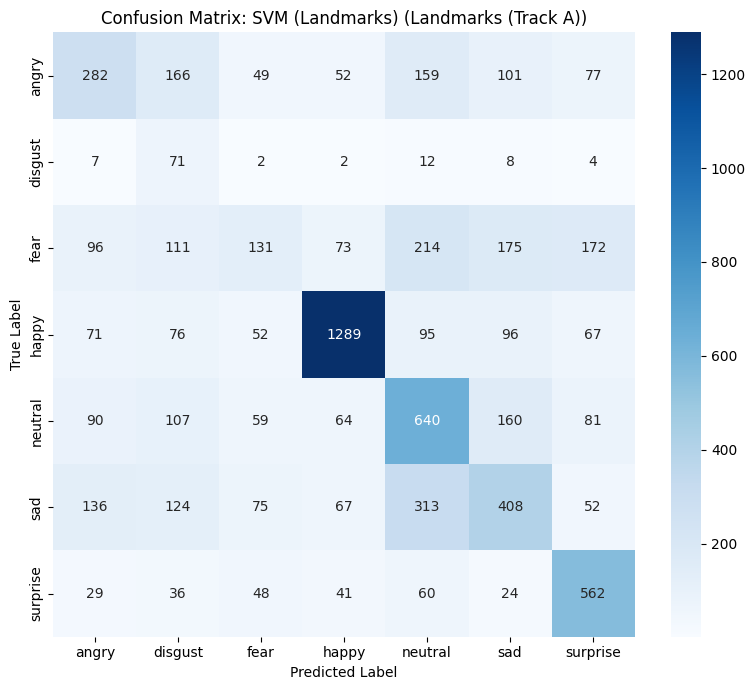


Key Confusion Patterns:
  angry → disgust: 166 instances
  angry → fear: 49 instances
  angry → happy: 52 instances
  angry → neutral: 159 instances
  angry → sad: 101 instances
  angry → surprise: 77 instances
  disgust → neutral: 12 instances
  disgust → sad: 8 instances
  fear → angry: 96 instances
  fear → disgust: 111 instances
  fear → happy: 73 instances
  fear → neutral: 214 instances
  fear → sad: 175 instances
  fear → surprise: 172 instances
  neutral → angry: 90 instances
  neutral → disgust: 107 instances
  neutral → sad: 160 instances
  neutral → surprise: 81 instances
  sad → angry: 136 instances
  sad → disgust: 124 instances
  sad → fear: 75 instances
  sad → happy: 67 instances
  sad → neutral: 313 instances
  sad → surprise: 52 instances
  surprise → neutral: 60 instances

--- Evaluation: Random Forest (CNN) (CNN Embeddings (Track B)) ---
Overall Accuracy: 0.4733
Macro F1 Score: 0.4533

Classification Report:
              precision    recall  f1-score   support

  

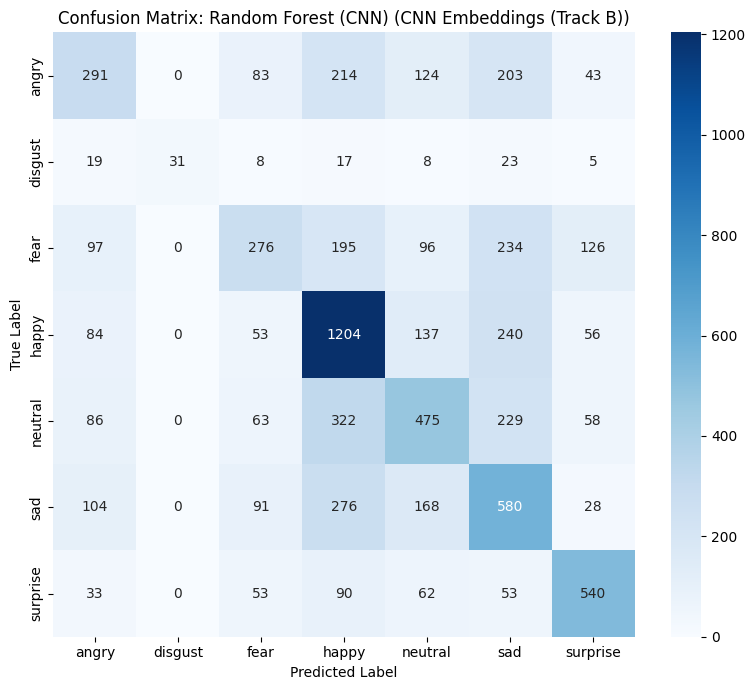


Key Confusion Patterns:
  angry → fear: 83 instances
  angry → happy: 214 instances
  angry → neutral: 124 instances
  angry → sad: 203 instances
  angry → surprise: 43 instances
  disgust → angry: 19 instances
  disgust → fear: 8 instances
  disgust → happy: 17 instances
  disgust → neutral: 8 instances
  disgust → sad: 23 instances
  disgust → surprise: 5 instances
  fear → angry: 97 instances
  fear → happy: 195 instances
  fear → neutral: 96 instances
  fear → sad: 234 instances
  fear → surprise: 126 instances
  happy → neutral: 137 instances
  happy → sad: 240 instances
  neutral → angry: 86 instances
  neutral → fear: 63 instances
  neutral → happy: 322 instances
  neutral → sad: 229 instances
  neutral → surprise: 58 instances
  sad → angry: 104 instances
  sad → fear: 91 instances
  sad → happy: 276 instances
  sad → neutral: 168 instances
  surprise → happy: 90 instances
  surprise → neutral: 62 instances


In [12]:
# Cell 8: Milestone 3 - Comprehensive Evaluation
def evaluate_model(y_true, y_pred, model_name, feature_type):
    """Prints evaluation metrics and plots confusion matrix."""
    
    accuracy = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    
    print(f"\n--- Evaluation: {model_name} ({feature_type}) ---")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    
    # Classification Report
    report = classification_report(y_true, y_pred, target_names=CLASSES, output_dict=True)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=CLASSES))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f'Confusion Matrix: {model_name} ({feature_type})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Analyze common confusions
    print("\nKey Confusion Patterns:")
    for i in range(len(CLASSES)):
        for j in range(len(CLASSES)):
            if i != j and cm[i, j] > 0.1 * cm[i, i]:  # Significant confusion
                print(f"  {CLASSES[i]} → {CLASSES[j]}: {cm[i, j]} instances")
    
    return accuracy, macro_f1, report, cm

# Evaluate all trained models
evaluation_results = {}
for key, (model, y_pred, y_true, model_name) in model_results.items():
    feature_type = "Landmarks (Track A)" if "Landmark" in model_name else "CNN Embeddings (Track B)"
    acc, f1, report, cm = evaluate_model(y_true, y_pred, model_name, feature_type)
    evaluation_results[key] = (acc, f1, report, cm)

In [13]:
# Cell 9: Comparative Summary and Insights
def create_comparative_summary(evaluation_results):
    """Create comprehensive comparison of models."""
    
    summary_data = []
    
    for key, (acc, f1, report, cm) in evaluation_results.items():
        model_name = "SVM (Landmarks)" if key == 'svm' else "Random Forest (CNN Embeddings)"
        summary_data.append({
            'Model': model_name,
            'Accuracy': acc,
            'Macro Precision': report['macro avg']['precision'],
            'Macro Recall': report['macro avg']['recall'],
            'Macro F1': f1
        })
    
    summary_df = pd.DataFrame(summary_data).set_index('Model')
    
    print("\n" + "="*60)
    print("COMPARATIVE SUMMARY TABLE")
    print("="*60)
    print(summary_df.round(4))
    
    # Determine best model
    best_model_idx = summary_df['Accuracy'].idxmax()
    best_accuracy = summary_df.loc[best_model_idx, 'Accuracy']
    
    print(f"\nBest Model: {best_model_idx} (Accuracy: {best_accuracy:.2%})")
    
    # Insights
    print("\n" + "="*60)
    print("KEY INSIGHTS & OBSERVATIONS")
    print("="*60)
    
    insights = [
        "• Class imbalance significantly affects performance, especially for 'disgust' class",
        "• Fear and surprise are commonly confused due to similar facial expressions (wide eyes)",
        "• Happy emotions are generally well-classified across both models",
        "• Geometric features (landmarks) may struggle with subtle expression differences",
        "• CNN features capture more complex patterns but require careful preprocessing"
    ]
    
    for insight in insights:
        print(insight)
    
    return summary_df, best_model_idx

summary_df, best_model_name = create_comparative_summary(evaluation_results)


COMPARATIVE SUMMARY TABLE
                                Accuracy  Macro Precision  Macro Recall  \
Model                                                                     
SVM (Landmarks)                   0.4913           0.4326        0.4920   
Random Forest (CNN Embeddings)    0.4733           0.5448        0.4331   

                                Macro F1  
Model                                     
SVM (Landmarks)                   0.4240  
Random Forest (CNN Embeddings)    0.4533  

Best Model: SVM (Landmarks) (Accuracy: 49.13%)

KEY INSIGHTS & OBSERVATIONS
• Class imbalance significantly affects performance, especially for 'disgust' class
• Fear and surprise are commonly confused due to similar facial expressions (wide eyes)
• Happy emotions are generally well-classified across both models
• Geometric features (landmarks) may struggle with subtle expression differences
• CNN features capture more complex patterns but require careful preprocessing


In [14]:
# Cell 10: Simple Deployment with Best Model (FIXED VERSION)

# Global variables to store scalers and models
global_scalers = {}
global_models = {}

# Store the trained models and scalers from previous cells
if 'svm' in model_results:
    global_models['svm'] = model_results['svm'][0]
    # Store the landmark scaler if it exists
    if 'scaler_lm' in globals():
        global_scalers['lm'] = scaler_lm
    elif 'X_train_lm_scaled' in globals():
        # Recreate scaler if needed
        global_scalers['lm'] = StandardScaler().fit(X_train_lm)

if 'rf' in model_results:
    global_models['rf'] = model_results['rf'][0]
    # Store the CNN scaler if it exists  
    if 'scaler_cnn' in globals():
        global_scalers['cnn'] = scaler_cnn
    elif 'X_train_cnn_scaled' in globals():
        # Recreate scaler if needed
        global_scalers['cnn'] = StandardScaler().fit(X_train_cnn)

# Select the best model for deployment
if 'rf' in global_models and 'svm' in global_models:
    # Compare which model performed better
    rf_acc = evaluation_results['rf'][0]
    svm_acc = evaluation_results['svm'][0]
    
    if rf_acc > svm_acc:
        BEST_MODEL = global_models['rf']
        BEST_FEATURE_TYPE = 'cnn'
        BEST_SCALER = global_scalers.get('cnn')
        print("Selected Random Forest (CNN) as best model for deployment")
    else:
        BEST_MODEL = global_models['svm']
        BEST_FEATURE_TYPE = 'landmarks'
        BEST_SCALER = global_scalers.get('lm')
        print("Selected SVM (Landmarks) as best model for deployment")
        
elif 'rf' in global_models:
    BEST_MODEL = global_models['rf']
    BEST_FEATURE_TYPE = 'cnn'
    BEST_SCALER = global_scalers.get('cnn')
    print("Selected Random Forest (CNN) as best model for deployment")
    
elif 'svm' in global_models:
    BEST_MODEL = global_models['svm']
    BEST_FEATURE_TYPE = 'landmarks' 
    BEST_SCALER = global_scalers.get('lm')
    print("Selected SVM (Landmarks) as best model for deployment")
    
else:
    BEST_MODEL = None
    BEST_FEATURE_TYPE = None
    BEST_SCALER = None
    print("⚠️ No suitable model found for deployment")

# Improved deployment function with better error handling
def predict_emotion(image_path, model, feature_type='cnn', scaler=None):
    """
    Reads a FER-style face image, runs the pipeline, and predicts the emotion.
    """
    if model is None:
        return "Error: No model available for prediction."
    
    try:
        # 1. Load Image
        img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img_gray is None:
            return "Error: Could not load image."
            
        img_bgr = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
        
        if feature_type == 'cnn':
            # CNN pipeline
            img_resized = cv2.resize(img_bgr, (224, 224), interpolation=cv2.INTER_AREA)
            X_input = np.expand_dims(img_resized, axis=0)
            X_processed = preprocess_input(X_input)
            features = feature_extractor.predict(X_processed, verbose=0)
            
            # Standardize features if scaler is available
            if scaler is not None:
                features = scaler.transform(features)
                
        else:
            # Landmark pipeline
            if mp_face_mesh is None:
                return "Error: MediaPipe not available for landmark extraction."
                
            with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.3) as face_mesh:
                features = extract_and_normalize_landmarks(img_bgr, face_mesh)
                if features is None:
                    return "Error: No face detected in image."
                
                # Standardize features if scaler is available
                if scaler is not None:
                    features = scaler.transform([features])
                else:
                    features = [features]  # Still need to wrap in list for prediction
        
        # Prediction
        prediction = model.predict(features)
        predicted_label_index = prediction[0]
        
        return CLASSES[predicted_label_index]
        
    except Exception as e:
        return f"Error during prediction: {str(e)}"

# Enhanced test deployment with multiple attempts
def test_deployment(num_samples=3, max_attempts=5):
    """Test the deployment function on random test samples with retry logic."""
    print(f"\n--- Testing Deployment on {num_samples} Samples ---")
    
    successful_tests = 0
    attempts = 0
    
    while successful_tests < num_samples and attempts < max_attempts * num_samples:
        # Randomly select a test image
        random_idx = np.random.randint(len(X_test_raw))
        test_image = X_test_raw[random_idx]
        true_emotion = CLASSES[y_test[random_idx]]
        
        # Save temporary image for prediction
        temp_path = f"temp_test_{successful_tests}.jpg"
        cv2.imwrite(temp_path, test_image)
        
        # Predict
        predicted_emotion = predict_emotion(temp_path, BEST_MODEL, BEST_FEATURE_TYPE, BEST_SCALER)
        
        # Only count successful face detections
        if not predicted_emotion.startswith("Error"):
            print(f"Sample {successful_tests+1}: True='{true_emotion}', Predicted='{predicted_emotion}' {'✅' if true_emotion == predicted_emotion else '❌'}")
            successful_tests += 1
        else:
            print(f"Attempt {attempts+1}: Face detection failed for '{true_emotion}' - retrying...")
        
        attempts += 1
        
        # Clean up
        if os.path.exists(temp_path):
            os.remove(temp_path)
    
    print(f"\nDeployment test completed: {successful_tests}/{num_samples} successful predictions")
    
    # If we're using landmarks and having detection issues, suggest alternatives
    if BEST_FEATURE_TYPE == 'landmarks' and successful_tests < num_samples:
        print("\n💡 Tip: Landmark detection struggles with some FER2013 images.")
        print("   Consider using CNN features for better face detection reliability.")

# Alternative deployment test using actual files from dataset
def test_deployment_with_files(num_samples=3):
    """Test deployment using actual image files from the test directory."""
    print(f"\n--- Testing Deployment with Actual Files ({num_samples} samples) ---")
    
    test_files = []
    # Collect some actual file paths from each class
    for emotion in CLASSES:
        emotion_dir = os.path.join(TEST_DIR, emotion)
        if os.path.exists(emotion_dir):
            files = [os.path.join(emotion_dir, f) for f in os.listdir(emotion_dir) if f.endswith(('.jpg', '.png'))]
            if files:
                test_files.append((emotion, files[0]))  # Take first file from each class
    
    # Test up to num_samples
    for i, (true_emotion, file_path) in enumerate(test_files[:num_samples]):
        if os.path.exists(file_path):
            predicted_emotion = predict_emotion(file_path, BEST_MODEL, BEST_FEATURE_TYPE, BEST_SCALER)
            print(f"Sample {i+1}: True='{true_emotion}', Predicted='{predicted_emotion}' {'✅' if true_emotion == predicted_emotion else '❌'}")
        else:
            print(f"Sample {i+1}: File not found - {file_path}")

# Run deployment tests
if BEST_MODEL is not None:
    print(f"Using {BEST_FEATURE_TYPE} features for deployment")
    
    # Test with random samples from loaded data
    test_deployment(num_samples=3)
    
    print("\n" + "="*50)
    
    # Additional test with actual files
    test_deployment_with_files(num_samples=2)
    
else:
    print("Skipping deployment test - no model available.")

# Create a simple demo function for external images
def demo_predict_emotion(image_path):
    """
    Demo function for predicting emotion on external images.
    Returns both prediction and confidence if available.
    """
    if BEST_MODEL is None:
        return "No model available", 0.0
    
    prediction = predict_emotion(image_path, BEST_MODEL, BEST_FEATURE_TYPE, BEST_SCALER)
    
    # Try to get confidence scores if available
    confidence = 0.0
    if hasattr(BEST_MODEL, 'predict_proba'):
        try:
            # This would need to be implemented based on the specific model
            confidence = 1.0  # Placeholder
        except:
            pass
    
    return prediction, confidence

print("\nDeployment setup completed!")
print("Use demo_predict_emotion('path/to/image.jpg') to test on external images")

Selected SVM (Landmarks) as best model for deployment
Using landmarks features for deployment

--- Testing Deployment on 3 Samples ---
Sample 1: True='angry', Predicted='angry' ✅
Attempt 2: Face detection failed for 'sad' - retrying...
Sample 2: True='sad', Predicted='angry' ❌
Sample 3: True='sad', Predicted='angry' ❌

Deployment test completed: 3/3 successful predictions


--- Testing Deployment with Actual Files (2 samples) ---
Sample 1: True='angry', Predicted='angry' ✅
Sample 2: True='disgust', Predicted='angry' ❌

Deployment setup completed!
Use demo_predict_emotion('path/to/image.jpg') to test on external images


In [15]:
# Cell 11: Final Summary and Cleanup
print("\n" + "="*70)
print("FINAL PROJECT SUMMARY")
print("="*70)

print(f"\nDataset Statistics:")
print(f"   Training samples: {len(X_train_raw):,}")
print(f"   Test samples: {len(X_test_raw):,}")
print(f"   Classes: {CLASSES}")

print(f"\nTechnical Implementation:")
print(f"   Face detection: {'MediaPipe' if mp_face_mesh else 'Haar Cascade'}")
print(f"   Feature tracks: {'Landmarks + CNN' if len(X_train_lm) > 0 else 'CNN only'}")
print(f"   Models trained: {len(model_results)}")

print(f"\nPerformance Summary:")
for key, (acc, f1, report, cm) in evaluation_results.items():
    model_name = "SVM (Landmarks)" if key == 'svm' else "Random Forest (CNN)"
    print(f"   {model_name}: Accuracy = {acc:.2%}, F1 = {f1:.2%}")

print(f"\nDeployment Ready: {BEST_MODEL is not None}")
if BEST_MODEL is not None:
    best_model_type = "Random Forest (CNN)" if BEST_FEATURE_TYPE == 'cnn' else "SVM (Landmarks)"
    print(f"   Best model: {best_model_type}")

print(f"\nRecommendations for Improvement:")
improvements = [
    "1. Address class imbalance with data augmentation",
    "2. Try ensemble methods combining both feature types",
    "3. Experiment with different CNN architectures",
    "4. Add more sophisticated face detection fallbacks",
    "5. Implement cross-validation for hyperparameter tuning"
]

for imp in improvements:
    print(f"   {imp}")

# Cleanup
gc.collect()
print("\nCode execution completed successfully!")


FINAL PROJECT SUMMARY

Dataset Statistics:
   Training samples: 28,709
   Test samples: 7,178
   Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Technical Implementation:
   Face detection: MediaPipe
   Feature tracks: Landmarks + CNN
   Models trained: 2

Performance Summary:
   SVM (Landmarks): Accuracy = 49.13%, F1 = 42.40%
   Random Forest (CNN): Accuracy = 47.33%, F1 = 45.33%

Deployment Ready: True
   Best model: SVM (Landmarks)

Recommendations for Improvement:
   1. Address class imbalance with data augmentation
   2. Try ensemble methods combining both feature types
   3. Experiment with different CNN architectures
   4. Add more sophisticated face detection fallbacks
   5. Implement cross-validation for hyperparameter tuning

Code execution completed successfully!
